## Tutorial: mapping snRNAseq data on Visium data
by Gabriele Scalia (gscalia@broadinstitute.org) and Tommaso Biancalani (tbiancal@broadinstitute.org)
- Healthy adult mouse brain tissue from the primary visual area (VISp).
- snRNAseq data (SmartSeq2) and spatial data (Visium).

### To start with:
- Download the annotated [snRNAseq data](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/visp_sn_tpm_small_0430.h5ad) to the `example/data` folder.
- Download the [Visium dataset](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/Allen-Visium_Allen1_cell_count.h5ad), and our [segmentation results](https://storage.googleapis.com/tommaso-brain-data/tangram_demo/Allen-Visium_Allen1_cell_centroids.pkl), to the `example/data` folder.

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'data/visp_sn_tpm_small_0430.h5ad')
adata = sc.read_h5ad(path)
adata.var_names_make_unique()

In [5]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'data/Allen-Visium_Allen1_cell_count.h5ad')
space_data = sc.read_h5ad(path)

In [6]:
'Restrict to non-empty voxels'
space_data = space_data[space_data.obs['cell_count'] > 0]

/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
'Choose genes for mapping'
# Visium and snRNAseq datasets contains many shared genes: we choose a subset of relevant markers.
marker_genes = mapping.utils.read_pickle('data/spacejams_visp_markers.pkl')  # load marker list
markers_in_space_data = set(marker_genes) & set(space_data.var.index) 
space_data = space_data[:, list(markers_in_space_data)]

In [9]:
'Load cells coordinates on Visium image'
cells_coordinates = mapping.utils.read_pickle('data/Allen-Visium_Allen1_cell_centroids.pkl')

In [10]:
'Extract all cell positions'
cells_positions = []
idx_count = 0
for index,rows in space_data.obs.iterrows(): # Allen1_cell_counts adata
    for i in range (0,len(cells_coordinates)//4): # Allen1_cell_centroids.pkl
        if (rows['x_plot'], rows['y_plot']) == (cells_coordinates[i,1], cells_coordinates[i,0]):
            cell_centroid_array = cells_coordinates[i,3]
            idx_count += 1
            cells_positions.append(cell_centroid_array)
            break # so that loop does not iterate on the variable after it has found one match.
idx_count

158

In [11]:
'Compute shared genes between single nuclei and spatial data'
# get matched indices between prior (ie spatial data) and snRNA-seq adata
# `selected_genes` contains (ordered) shared genes'
mask_prior_indices, mask_adata_indices, selected_genes =  mapping.utils.get_matched_genes(
    space_data.var_names, adata.var_names
)
len(selected_genes)

1326

In [12]:
'create matrixes to run the algorithm'
S = np.array(adata[:, mask_adata_indices].X)
G = np.array(space_data[:, mask_prior_indices].X)
d = np.array(space_data.obs.cell_count)/space_data.obs.cell_count.sum()

In [14]:
'Apply log(1+x) to snRNAseq data (optional - we do not use that for Visium data)';
# S = np.log(1+S)

In [15]:
'Select gpu/cpu for running Tangram'
device = torch.device('cuda:0')  # for gpu
# device = torch.device('cpu') # for cpu

In [16]:
'Define Tangram hyperparameters'
# refer to manuscript for their meaning
hyperparm = {'lambda_d' : 1, 'lambda_g1' : 1, 'lambda_g2' : 0, 'lambda_r' : 0,
            'lambda_count' : 1, 'lambda_f_reg' : 1}

In [17]:
'Define training hyperparameters'
learning_rate = 0.1
num_epochs = 6000

In [18]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, **hyperparm, target_count = space_data.obs.cell_count.sum()
)

In [19]:
'Train Tangram'
# Arguments: learning rate and the number of epochs.
# The output are the various loss terms (see manuscript)/
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (hyperaparamete)
output_all, F_out_all = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

0.05800403282046318 0.4344353675842285 nan 5191.064453125 2417.658447265625
0.009975343942642212 0.5960508584976196 nan 288.2975769042969 323.03546142578125
0.00977922324091196 0.5859529972076416 nan 2.25115966796875 299.21905517578125
0.009878046810626984 0.5818188786506653 nan 0.44775390625 188.5487518310547
0.010017184540629387 0.5792696475982666 nan 1.8358154296875 152.49005126953125
0.010010572150349617 0.5780906677246094 nan 2.04052734375 125.6500473022461
0.010044211521744728 0.5771864056587219 nan 1.5433349609375 109.32891845703125
0.009966515004634857 0.5763846039772034 nan 1.78729248046875 95.24937438964844
0.009986971504986286 0.5758183598518372 nan 0.4473876953125 84.57505798339844
0.009901486337184906 0.5753245949745178 nan 0.4549560546875 76.52251434326172
0.009948273189365864 0.5749337673187256 nan 0.6497802734375 68.96569061279297
0.010000050999224186 0.5746163725852966 nan 1.3946533203125 62.666259765625
0.009979333728551865 0.5743152499198914 nan 1.503173828125 58.528

In [20]:
output, F_out = output_all, F_out_all

In [21]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(adata.obs.subclass)
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

L4       Vip     Lamp5         L5 NP       Sst     L5 IT  \
0  0.000052  0.035502  0.249088  2.653464e-06  0.076643  0.010922   
1  0.598105  0.558661  0.307823  2.398094e-05  0.603313  0.001224   
2  0.046245  0.609578  0.415535  2.010450e-06  0.923352  0.074390   
3  0.025577  3.636772  0.192165  6.628071e-07  0.001607  0.000006   
4  0.423281  0.204402  1.075298  4.675334e-02  0.000026  0.000011   

          Oligo     L6 PT     L6 IT      Sncg  ...     Astro     L5 PT  \
0  3.182316e-02  0.067814  0.122242  0.055065  ...  0.053991  0.000032   
1  2.103993e-02  0.001107  0.166843  0.172718  ...  0.156958  0.162941   
2  2.816934e-02  0.000012  0.192362  0.019253  ...  0.185232  0.283152   
3  9.323594e-07  0.000003  0.255272  0.005448  ...  0.068509  0.000006   
4  1.059572e-01  0.086883  0.024829  0.001359  ...  0.098881  0.001259   

        L6b          Endo          Peri         Meis2  Macrophage  \
0  0.000049  2.063868e-07  7.626109e-09  2.659556e-07    0.164468   
1  0.000007  3.915382e-08  9.950490e-09  1.863999e-07    0.267209   
2  0.000004  1.752577e-02  1.844537e-04  1.090774e-07    0.034055   
3  0.000001  1.691334e-01  1.673518e-04  5.459950e-02    0.010755   
4  0.000005  7.236749e-02  5.644456e-09  2.395223e-02    0.041535   

             CR      VLMC       SMC  
0  1.517668e-09  0.059651  0.011587  
1  7.600478e-10  0.032878  0.031958  
2  7.030457e-10  0.050642  0.044189  
3  3.187942e-10  0.138081  0.243519  
4  7.329397e-10  0.076021  0.000002  

[5 rows x 22 columns]

In [22]:
'Example: visualize spatial probability of cell type L6b'
plt.scatter(x=space_data.obs.x, y=space_data.obs.y, c=prob_assign['L6b'], s=100, cmap='PuBu');

**Deconvolution**

In [23]:
'Assign cell type to each spatial voxel'
# create a dataframe x, y, cell count for each voxel, and cell centroids for each voxel
df_vox_cells = pd.DataFrame({'x' : space_data.obs.x, 'y' : space_data.obs.y, 'cell_n' : space_data.obs.cell_count, 'centroids' : cells_positions})
# get the most probable voxel for each cell
resulting_voxels = np.argmax(output, axis=1)
# create a list with filtered cells and the voxels where they have been placed with the 
#highest probability a cell i is filtered if F_i > 0.5'
filtered_voxels_to_types = [(j, adata.obs.subclass[k]) for i, j, k in zip(F_out, resulting_voxels, range(len(adata))) if i > 0.5]
filtered_voxels_to_types[:5]

[(96, 'L4'), (148, 'Vip'), (70, 'L4'), (126, 'Sst'), (35, 'Lamp5')]

For example: `[(109, 'Sst'), (96, 'Vip'), (33, 'Lamp5'), (44, 'Sst'), (102, 'Pvalb')]`
means that voxel 109 has a cell _Sst_, voxel 96 has a cell _Vip_, and so on. The length of `filtered_voxels_to_types` is equal to the number of mapped cells.

In [24]:
'Create a dataframe with the number of cell types in each voxel'
for index, i in enumerate(df_classes.columns):
    df_vox_cells[i] = 0
for k, v in filtered_voxels_to_types:
    df_vox_cells.iloc[k, df_vox_cells.columns.get_loc(v)] += 1

In [25]:
df_vox_cells.head()

x      y  cell_n  \
CGCTGTGACGCCGCAC-1  13204  13187       1   
ATGCACTACCGCATTG-1  13838  12820       4   
CAGATACTAACATAGT-1  13521  13003       4   
GATCGACACTATCTGA-1  13839  13185       5   
ATAGAGTACTGGGACA-1  13522  13368       3   

                                                            centroids  L4  \
CGCTGTGACGCCGCAC-1                                       [[833, 826]]   0   
ATGCACTACCGCATTG-1   [[802, 869], [810, 869], [811, 874], [812, 869]]   1   
CAGATACTAACATAGT-1   [[816, 852], [818, 851], [821, 852], [823, 854]]   0   
GATCGACACTATCTGA-1  [[828, 874], [829, 870], [831, 868], [833, 876...   0   
ATAGAGTACTGGGACA-1               [[836, 850], [836, 854], [845, 855]]   1   

                    Vip  Lamp5  L5 NP  Sst  L5 IT  ...  Astro  L5 PT  L6b  \
CGCTGTGACGCCGCAC-1    0      1      0    0      0  ...      0      0    0   
ATGCACTACCGCATTG-1    0      0      0    0      0  ...      0      0    0   
CAGATACTAACATAGT-1    0      1      0    0      0  ...      0      0    0   
GATCGACACTATCTGA-1    5      0      0    0      0  ...      0      0    0   
ATAGAGTACTGGGACA-1    0      2      0    0      0  ...      0      0    0   

                    Endo  Peri  Meis2  Macrophage  CR  VLMC  SMC  
CGCTGTGACGCCGCAC-1     0     0      0           0   0     0    0  
ATGCACTACCGCATTG-1     0     0      0           0   0     0    0  
CAGATACTAACATAGT-1     0     0      0           0   0     0    0  
GATCGACACTATCTGA-1     1     0      0           0   0     0    1  
ATAGAGTACTGGGACA-1     0     0      0           0   0     0    0  

[5 rows x 26 columns]

In [26]:
'Assign cell types to coordinates'
cell_types_mapped = mapping.utils.df_to_cell_types(df_vox_cells, list(df_classes.columns))

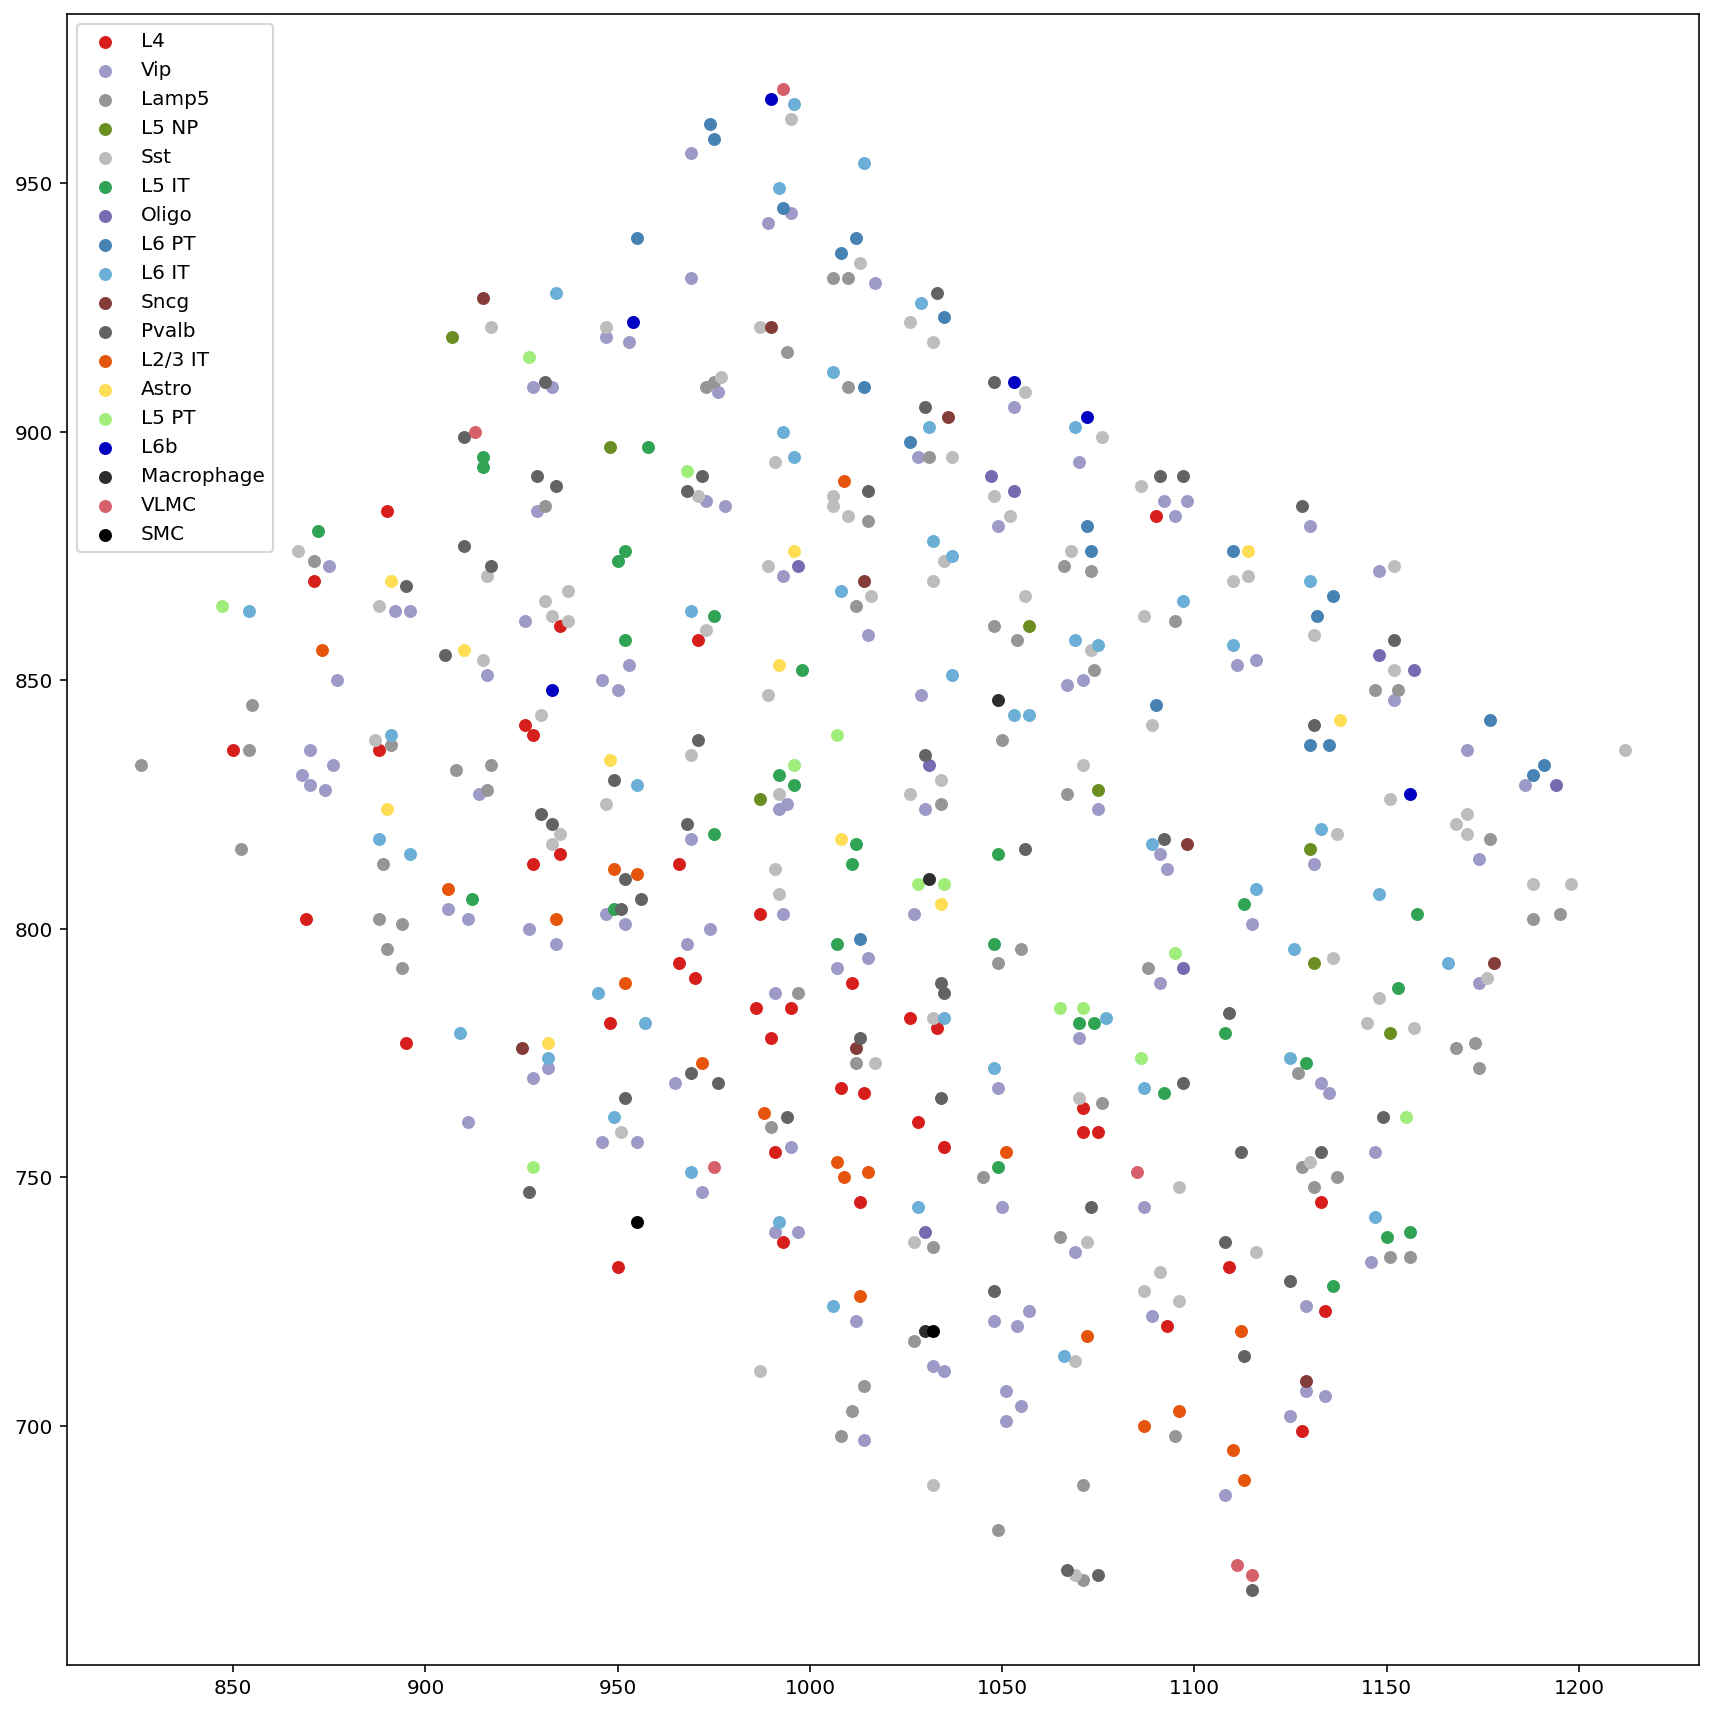

In [27]:
'Visualize all cells, using the colormap in the library'

plt.figure(figsize = (12,12))

for index, (k,v) in enumerate(cell_types_mapped.items()):
    if len(v) == 0:
        continue
    x_cells, y_cells = zip(*v)
    plt.scatter(y_cells, x_cells, s= 30, label=k, color=mapping.plot_utils.mapping_colors[k])
    
s_area = ((space_data.uns['spot_diameter_fullres']*space_data.uns['tissue_hires_scalef'])/2)**2

plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('all_types.png', dpi=300)

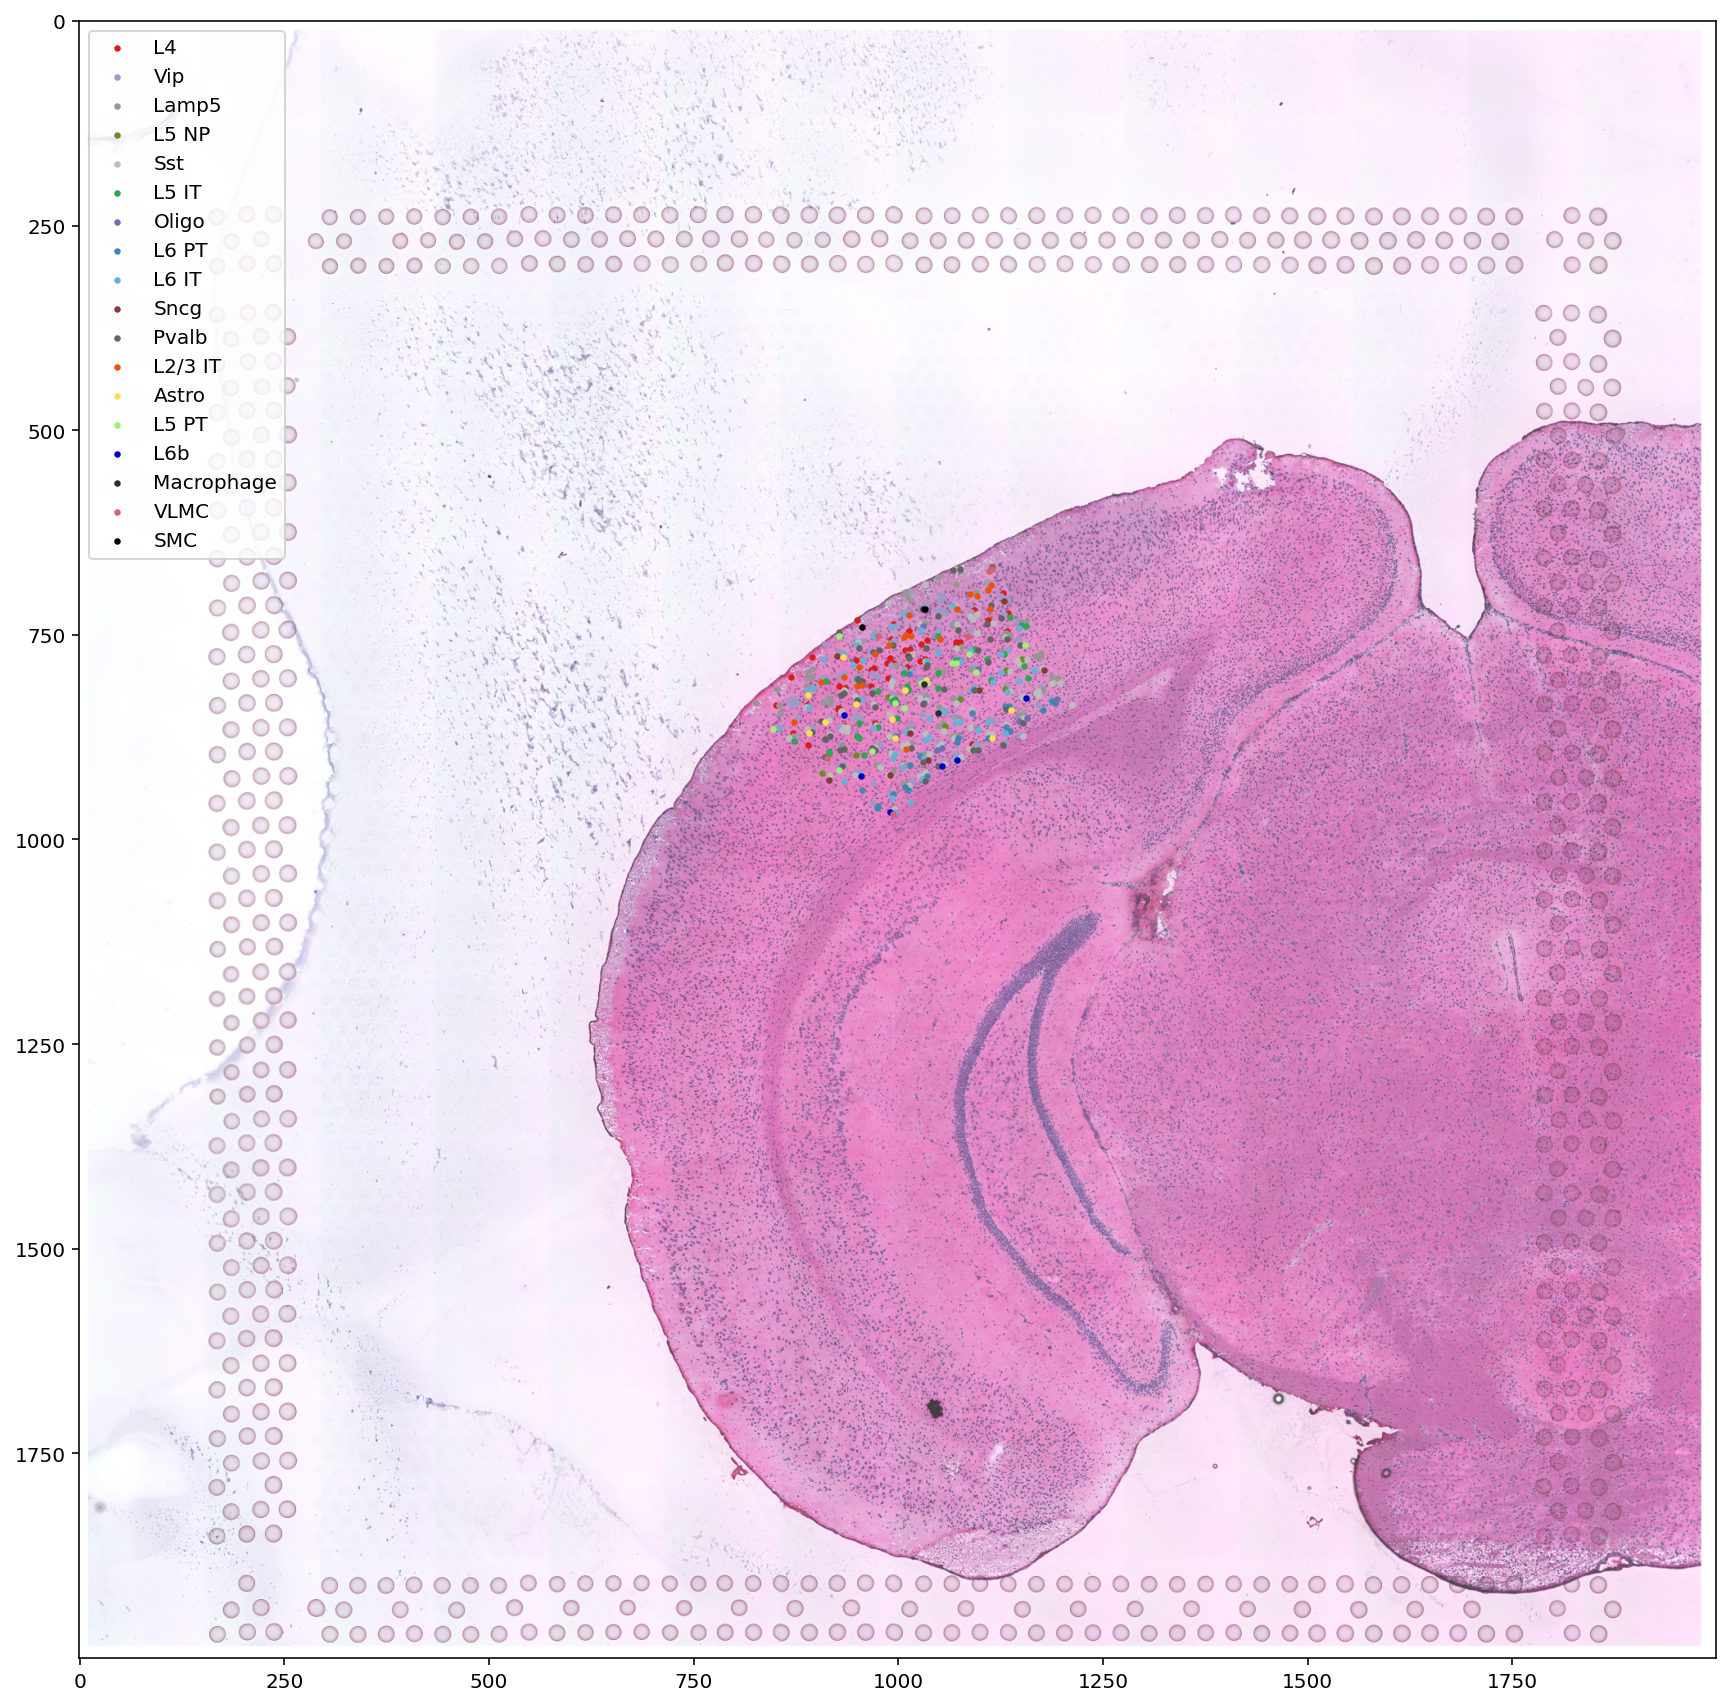

In [28]:
'Visualize all cells, using the colormap in the library'

plt.figure(figsize = (12,12))

plt.imshow(space_data.uns['image_hires'], alpha=0.8)

for index, (k,v) in enumerate(cell_types_mapped.items()):
    if len(v) == 0:
        continue
    x_cells, y_cells = zip(*v)
    plt.scatter(y_cells, x_cells, s=5, label=k, color=mapping.plot_utils.mapping_colors[k])
    
s_area = ((space_data.uns['spot_diameter_fullres']*space_data.uns['tissue_hires_scalef'])/2)**2

plt.legend(loc='upper left')
plt.tight_layout()

#plt.savefig('all_types_background.png', dpi=300)